# Modelbase Tutorial

MODELbase is a Python based wrapper around the most useful commands that allow you to **create** and **analyse** dynamic mathematical models of biological systems. It has been developed at the [Insitute for Quantitative and Theoretical Biology](http://www.qtb.hhu.de/) at the Heinrich-Heine University Düsseldorf, Germany. 

<a name="start"></a>
##  Getting started

In [2]:
# Import the necessary packages
import modelbase
import matplotlib.pyplot as plt
import numpy as np

Modelbase incorporates an easy construction method to define 'reactions'. Every model is defined by:
- model variables,
- model parameters,
- rate equations,
- stoichiometries.

With this information the system of differential equations is assembled **automatically**.


### Example 1: Modelling a simple chain of reactions
#### Model definition
We apply modelbase to simulate a simple chain of three reactions with two state variables "X" and "Y".

<img src="figures/exp1scheme.png" width="400" height="400" />

In [3]:
# Define metabolite species X and Y as a list
cl = ['X','Y']

Parameters:
- influx (v0),
- rate constant conversion X->Y (k1),
- rate constant for outflux (k2).

In [4]:
# Provide parameters in a form of dictionary
p = {'v0':1,
     'k1':0.5,
     'k2':0.1}

In [5]:
# Instantiate model and pass the parameters set
m = modelbase.Model(p)

The variables can now be accessed by ```m.par.name```

In [6]:
print('The rate of v0 is', m.par.v0)

The rate of v0 is 1


Model assumptions:
- constant influx of X, 
- irreversible conversion of X to Y
- irreversible outflux of Y.

In [7]:
# Add the variables. Variables are ALWAYS defined by names (i.e. strings). 
# These are later used to access and identify the variables and their values.
m.set_cpds(cl)

To define the reaction rates we need to:
1. define a rate function
   - all the rate functions always accept the model parameters as first argument,
   - the remaining arguments are metabolite concentrations as defined in the ```set_rate``` command
2. define the stoichiometries
   - the stoichiometries can be defined by the rate: ```m.set_stoichiometry```
   - or by the compound name ```set_stoichiometry_byCpd```

In [8]:
# Define the reaction rate of the function that produces X
# It is particulary simple, because it is constant
# We set the rate by providing the name of the rate, function and compounds that are passed to the function (here none)
m.set_rate('v0',lambda p:p.v0)

We have used here Python's *lambda* expression. There are numbers of available lambda tutorials out there like [this](https://pythonspot.com/python-lambda/) or [this](https://www.python-course.eu/python3_lambda.php) but particularly nice is the [Stupid lambda tricks](http://p-nand-q.com/python/lambda.html) addressed to "wacky geek fun hackers".

In [9]:
# Define the reaction rate of the irreversible v1 where one X is consumed and one Y is produced
# We assume simple mass-action kinetics 
def v1(p,x):
    return p.k1*x

In [10]:
# Set the rate and pass to the v1 concentrations of X and Y
m.set_rate('v1',v1,'X')

In [11]:
# Define the reaction rate of the irreversible v2 and set the rate
# We (again) assume simple mass-action kinetics
def v2(p,y):
    return p.k2*y

m.set_rate('v2',v2,'Y')

In [12]:
# Set the stoichiometry of all three reactions 
m.set_stoichiometry('v0',{'X':1})
m.set_stoichiometry('v1',{'X':-1,'Y':1})
m.set_stoichiometry('v2',{'Y':-1})

In [13]:
# You can check the stoichiometries of the model with the special method
m.stoichiometries

{'v0': {'X': 1}, 'v1': {'X': -1, 'Y': 1}, 'v2': {'Y': -1}}

Mathematically, this results in the two model equations:

$\frac{dX}{dt} = v_0 - k_1*[X]$

$\frac{dY}{dt} = k_1*[X] - k_2*[Y]$

therefore it might be more intuitive to set the stoichiometry by the compound name, which is also supported by the modelbase.
```
m.set_stoichiometry_byCpd('X',{'v0':1, 'v1':-1})
m.set_stoichiometry_byCpd('Y',{'v1':1,'v2':-1})
```

#### Model analysis
To perform any type of simulations we create a new simulate object using ```modelbase.Simulator``` class

In [14]:
s = modelbase.Simulator(m)

There is a number of build in methods to integrate. The simplest one is the integration over a given period of time ```timeCourse```. The method takes as the first argument **time interval** and as a second the **initial conditions**, and returns an array of state variables Several optional arguments are available to customise the settings of the integration method. 

In [15]:
# Define time for integration
time = np.linspace(0,100,1000)

In [16]:
# Integrate
s.timeCourse(time,np.zeros(2));

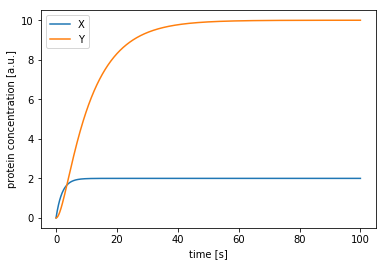

In [17]:
# Plot the temporal evolution of X and Y
plt.figure()
plt.plot(s.getT(),s.getY())
plt.legend(m.cpdNames)
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()

---
<a name="linchain"></a>
## Example 1: Modelling reaction chain assuming that $v_1$ is reversible
We assume now reversible conversion of X to Y

<img src="figures/exp1scheme.png" width="400" height="400" />

where the rate of v1 can be described as $v_1 = k_{1p}*[X] - k_{1m}*[Y]$

In [18]:
# Provide now 4 parameters with k1 forward and backward
p = {'v0':1,
     'k1p':0.5,
     'k1m':1,
     'k2':0.1}

In [19]:
# Reinstantiate model with the new parameter set
m = modelbase.Model(p)

In [20]:
# Add compounds, unchanged reactions v1 and v2 and set stoichiometries for them
m.set_cpds(cl)

m.set_rate('v0',lambda p:p.v0)
m.set_stoichiometry('v0',{'X':1})

m.set_rate('v2',v2,'Y')
m.set_stoichiometry('v2',{'Y':-1})

In [21]:
# Redefine the kinetics of v1 with a reversible mass-action kinetics
def v1(p,x,y):
    return p.k1p*x - p.k1m*y

m.set_rate('v1',v1,'X','Y') # tells the model to pass concentrations of X and Y
m.set_stoichiometry('v1',{'X':-1,'Y':1}) # one X destroyed, one Y created

In [22]:
# Check the current stoichiometry
m.stoichiometries

{'v0': {'X': 1}, 'v2': {'Y': -1}, 'v1': {'X': -1, 'Y': 1}}

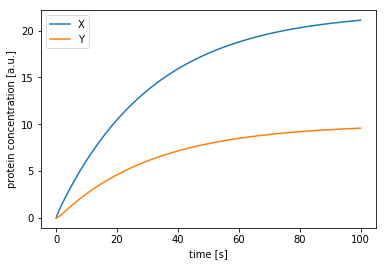

In [23]:
# create modelbase.simulate.Simulator object
s = modelbase.Simulator(m)
# run a timecourse
s.timeCourse(np.linspace(0,100,1000),np.zeros(2))

#plt.interactive(True)
plt.figure()
plt.plot(s.getT(),s.getY())
plt.legend(m.cpdNames)
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()


---
<a name="linchainreq"></a>
## Example 2: Modelling a simple chain of reactions using a rapid equilibrium approximation
This example illustrates how to simulate a simple chain of three reactions where one of the reactions is assumed to operate on much faster time scale than other reactions and therefore can be assumed to be in an equilibrium.

In the reaction chain:
<img src="figures/exp1scheme.png" width="400" height="400" />
$X \Longleftrightarrow Y$ is assumed to be very fast, i.e. in equilibrium.

Approach: 
1. We define one 'slow' variable A (where A = X+Y).
2. We instantiate model as *AlgModel*, because we will use the algebraic module,  calculating X and Y from A:
  - we define algebraic function (`feq`) that accepts as arguments parameter object and the slow-changing variable (A) and returns an array with all derived variables ([X,Y]),
  - we define the algebraic module object, passing the parameters and function,
  - we add the module object to the model using `add_algebraicModule` method,
3. We can use any quantity A, X, Y in our rate equations.

In [24]:
# define slow variable A
cl = ['A']
p = {'v0':1,'k2':0.1}

In [25]:
# instantiate model as AlgmModel
m = modelbase.Model(p)

In [26]:
m.set_cpds(cl)

In [27]:
# this function defines the algebraic module. It accepts as first argument
# the parameters, then the slow-changing variable
# output are the two derived variables X and Y
def feq(par,y):
    return np.array([y[0]/(1+par.K),y[0]*par.K/(1+par.K)])

In [28]:
# add K to your parameters
m.par.K = 5

In [29]:
# add algebraic module object to the model by specifying the names of the variables
m.add_algebraicModule(feq, "eqm", ['A'],['X','Y'])


# constant influx to the pool A
m.set_rate('v0',lambda p:p.v0)
m.set_stoichiometry('v0',{'A':1})

# mass-action outflux from the pool A
# note that rate expression depends on variable Y!
def v2(p,y):
    return p.k2*y

m.set_rate('v2',v2,'Y')
m.set_stoichiometry('v2',{'A':-1})

In [30]:
# use the Simulate class to get access to the variables X and Y
s = modelbase.Simulator(m)
s.timeCourse(np.linspace(0,100,1000),np.zeros(1));

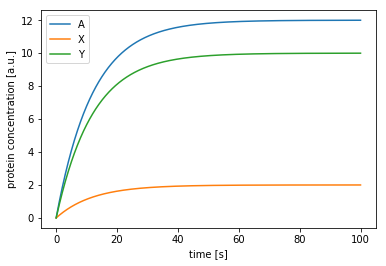

In [31]:
plt.figure()
plt.plot(s.getT(),s.getY())
plt.legend(m.allCpdNames())
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()

---
<a name="timedependent"></a>
## Example 3: Modelling a system with a time dependent external conditions
This example illustrates how to simulate reactions that are sensitive to time dependent external conditions, extremly useful in the context of biological systems, where for instance, many enzymes are known to change their activity depending on time. 

In the simple 2-reaction chain influx is simulated by a time-dependent *t* function $$e^{-l*t}$$ with parameter *l* set to 1, and outflux with mass-action kinetics

<img src="attachment:exp3scheme.png" width="400" height="400" />

We first use Python \*\*kwargs argument to define time-dependent function. \*\*kwargs is used to pass a keyworded, variable-length argument dictionary to a function, here, by default the key 't' refers to time. Next, we set teh rate using specially dedicated model method *set_ratev* instead of *set_rate*

In [32]:
# Repeat previous steps to instantiate model
cl = ['X']
p = {'l':1,'k':0.1}

In [33]:
# instantiate model
m = modelbase.Model(p)

In [34]:
m.set_cpds(cl)

In [35]:
# define influx function using **kwargs 
def v0(p,**kwargs):
    return np.exp(-p.l*kwargs['t'])

In [36]:
# this rate must be set with 'ratev'
m.set_ratev('v0',v0)
m.set_stoichiometry('v0',{'X':1})

In [37]:
def v1(p,x):
    return p.k*x

In [38]:
m.set_rate('v1',v1,'X')
m.set_stoichiometry('v1',{'X':-1})

In [39]:
s = modelbase.Simulator(m)
s.timeCourse(np.linspace(0,50,500),np.zeros(1));

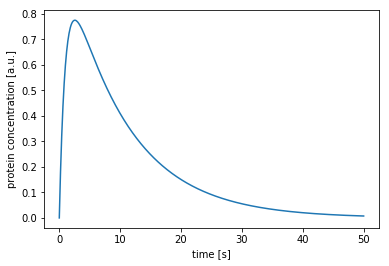

In [40]:
plt.figure()
plt.plot(s.getT(),s.getVar([0]))
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.show()

---
<a name="cascade"></a>
## Example 4: Modelling a simple protein kinase signalling cascade.

This example simulates a simple protein kinase signalling cascade. It employes time-dependent external stimulus, as in previous example, and illustrates how to use algebraic modules for conserved quantitites.

<img src="attachment:kinasescheme.png" width="400" height="400" />

Modelbase allows to simulate the change in concentration of each protein kinase with $\textrm{X}_i$ refering to inactive and $\textrm{X}$ to an active form. We are assuming here only one phosphorylation site and constitutively active, unspecific phosphatase. The reversion will be modelled with a mass-action kinetics.

A real-life example of a protein kinase signalling cascade can be a mitogen-activated protein kinase (MAP kinase). MAP kinase is a type of protein kinase that is specific to the amino acids serine and threonine. MAPKs are involved in directing cellular responses to a diverse array of stimuli, such as mitogens, osmotic stress, heat shock and proinflammatory cytokines. They regulate cell functions including proliferation, gene expression, differentiation, mitosis, cell survival, and apoptosis. MAPKs typically form multi-tiered pathway. 

#### Model assumptions
We apply algebraic modules for three conserved quantitites:
$$\begin{aligned}
\textrm{X} + \textrm{X}_i = \textrm{X}_{tot}\\
\textrm{Y} + \textrm{Y}_i = \textrm{Y}_{tot}\\
\textrm{Z} + \textrm{Z}_i = \textrm{Z}_{tot}
\end{aligned}$$
Let's assume that all the reaction rates are set to 1, phosphotase activity is modelled with a simple mass action kinetics with a rate constant set to 0.5 a.u. and time-dependent stimulus is once again given as a function $$e^{-l*t}$$ with parameter *l* set to 0.5 a.u.

In [41]:
cl = ['X','Y','Z']

In [69]:
# Provide parameters set in a form of dictionary
p = {'l':.5, 'k1':1., 'k2':1., 'k3':1., 'p':.5, 'tot':1}

In [70]:
# Instantiate the model
m = modelbase.Model(p)

In [71]:
# Set the compounds
m.set_cpds(cl)

In [72]:
# Define the algebraic module exploiting conserved quantitites
def conrel(par, y):
        return np.array([par.tot - y[0]])

In [73]:
# Add three algebraic modules, always returning the inactive form Xi, etc.
m.add_algebraicModule(conrel,"rapidEqx", ['X'],['Xi'])
m.add_algebraicModule(conrel,"rapidEqy", ['Y'],['Yi'])
m.add_algebraicModule(conrel,"rapidEqz", ['Z'],['Zi'])

In [74]:
# Define the time-dependent stimulus and set the rate (see Exercise 2)
# Note that rate of conversion depends on Xi (made accessible by algebraic module)
def v0(p,x,**kwargs):
    return x*np.exp(-p.l*kwargs['t'])

m.set_ratev('v0',v0,'Xi')
m.set_stoichiometry('v0',{'X':1})

In [75]:
# Define the kinases
def k1(p,x,y0):
    return p.k1*x*y0

m.set_rate('k1',k1,'X','Yi')
m.set_stoichiometry('k1',{'Y':1})

In [76]:
def k2(p,x,y0):
    return p.k2*x*y0

m.set_rate('k2',k2,'Y','Zi')
m.set_stoichiometry('k2',{'Z':1})

In [77]:
# Define the constitutively active, unspecific phosphatase
def phosph(p,x):
    return p.p * x

In [78]:
# Set the stoichiometry (here by the rate, alternatively the stoichiometry can be set by the compound name)
m.set_rate('p1',phosph,'X')
m.set_stoichiometry('p1',{'X':-1})

m.set_rate('p2',phosph,'Y')
m.set_stoichiometry('p2',{'Y':-1})

m.set_rate('p3',phosph,'Z')
m.set_stoichiometry('p3',{'Z':-1})

In [79]:
# Integrate the system over the time of 1 minute
s = modelbase.Simulator(m)
s.timeCourse(np.linspace(0,50,500),np.zeros(3));

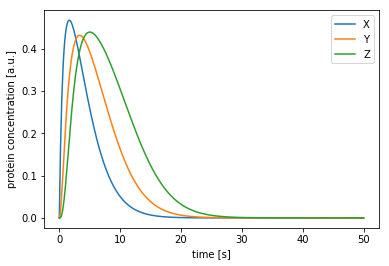

In [80]:
# Plot the temporal evolution of the protein kinase
plt.figure()
plt.plot(s.getT(),s.getVarsByName(cl))
plt.legend(cl)
plt.xlabel('time [s]')
plt.ylabel('protein concentration [a.u.]')
plt.draw_if_interactive()
plt.show()

***
<a name="isotope"></a>
## Example 5: Isotope-labelled models
This example illustrates how to construct an isotope-label specific model. We simulate the equilibration of isotope distribution in the aldolase reaction. 

<img src="attachment:aldolasereaction.png" width="400" height="400" />

### Model assumptions
The system includes reactions of triose-phosphate isomerase (TPI reaction)
$$\require{mhchem}$$  
$$\ce{GAP <=> DHAP}$$
and fructose-bisphosphate aldolase
$$\ce{GAP + DHAP <=> FBP}$$

### Approach
1. We construct the model using class *LabelModel* from the $\texttt{modelbase}$ package. 
2. Set the 'base' compounds and define the number of carbons using `add_base_cpd` method
  - by providing number of carbons (N) all isotope variants will be automatically expanded ($2^\textrm{N}$)
3. Set rates for reactions for all isotope labelling patterns of the substrates using `add_carbonmap_reaction` that takes as arguments:
  - rate name,
  - function,
  - a carbonmap: list defining how the carbons appear in the products,
  - subList: list of substrates,
  - prodList: list of products,
  - *args: list of arguments required to calculate rate using function fn (substrate names MUST come first)
  - **kwargs: required to define extra lables. Key 'extLabels', Value: list of labels, starting with 0

In [86]:
import modelbase.ratelaws as rl

In [87]:
# instantiate model
m = modelbase.LabelModel()

In [88]:
# define parameters
m.par.update({'kf_TPI': 1.0,
              'Keq_TPI': 21.0,
              'kf_Ald': 2000.0,
              'Keq_Ald': 7000.0})

In [89]:
# set the 'base' compounds. Second argument defines numbers of carbons
m.add_base_cpd('GAP', 3)
m.add_base_cpd('DHAP', 3)
m.add_base_cpd('FBP', 6)

In [90]:
# define a simple mass-action rate-law for the forward TPI reaction
def v1f(p,y):
    return rl.massAction(p.kf_TPI,y)

# define a carbon map reaction
m.add_carbonmap_reaction('TPIf',v1f,[2,1,0],['GAP'],['DHAP'],'GAP')

In [91]:
# define a simple mass-action rate-law for the backward TPI reaction
def v1r(p,y):
    return rl.massAction(p.kf_TPI/p.Keq_TPI,y)

m.add_carbonmap_reaction('TPIr',v1r,[2,1,0],['DHAP'],['GAP'],'DHAP')

In [92]:
# define a simple mass-action rate-law for the forward fructose-bisphosphate aldolase reaction
def v2f(p,y,z):
    return rl.massAction(p.kf_Ald,y,z)

m.add_carbonmap_reaction('Aldf',v2f,[0,1,2,3,4,5],['DHAP','GAP'],['FBP'],'DHAP','GAP')

In [93]:
# define a simple mass-action rate-law for the backward fructose-bisphosphate aldolase reaction
def v2r(p,y):
    return rl.massAction(p.kf_Ald/p.Keq_Ald,y)

m.add_carbonmap_reaction('Aldr',v2r,[0,1,2,3,4,5],['FBP'],['DHAP','GAP'],'FBP')

In [94]:
# set initial concentrations
GAP0 = 2.5e-5
DHAP0 = GAP0 * m.par.Keq_TPI
FBP0 = GAP0 * DHAP0 * m.par.Keq_Ald
y0d = {'GAP': GAP0,
       'DHAP': DHAP0,
       'FBP': FBP0}

In [97]:
# simulate equilibration of the labels. You can use again Simulator class
y0 = m.set_initconc_cpd_labelpos(y0d,labelpos={'GAP':0})
s = modelbase.Simulator(m)
T = np.linspace(0,20,1000)
s.timeCourse(T,y0);

Display the results for the Fructose 1,6-bisphosphatase (FBP) using `getLabelAtPos` method

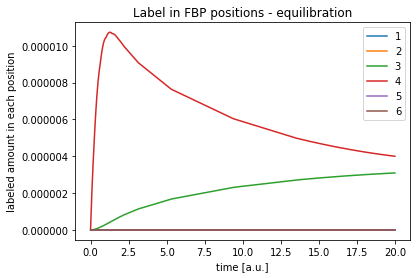

In [98]:
plt.figure()
plt.plot(s.getT(),np.vstack([s.getLabelAtPos('FBP',i) for i in range(6)]).transpose())
plt.legend([str(i+1) for i in range(6)])
plt.title("Label in FBP positions - equilibration")
plt.xlabel('time [a.u.]')
plt.ylabel('labeled amount in each position')
plt.show()